In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import scipy.linalg as sl
from tqdm.notebook import tqdm

from src.datasets_torch import StateND
from src.models import (DMDcModel, tlsDMDcModel, 
                        DMDcGPModel, tlsDMDcGPModel, GPModel)

from src.output_tracking_controller import TorchOutputTrackingController

torch.manual_seed(101)
torch.set_default_dtype(torch.float64)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Stuard-Landau Equation Solver

In [2]:
# Parameters
noise_level = {'zero_noise': 0.0, 'mid_noise': 0.05, 'high_noise': 0.1}

select_noise_level = 'high_noise'

params = {
    'mu': 0.1,
    'gamma': 1,
    'beta': 1,
    'dt': 0.01,
    'sigma': noise_level[select_noise_level] * torch.ones(2),
    'name': select_noise_level,
}

## Exact Model

In [3]:
def step(x, u, params):
    w = params['sigma'] * torch.randn((2,))
    r = x[0]
    theta = torch.arctan2(x[1], x[2])
    rp = r + params['dt'] * (params['mu'] * r - r**3 + u[0] + w[0])
    thetap = theta + params['dt'] * (params['gamma'] - params['beta'] * r**2 + u[1] + w[1] / r)
    return torch.tensor([
        torch.abs(rp),
        torch.sin(thetap),
        torch.cos(thetap)
    ])

In [4]:
def plot_trajectories(x_pred, inputs, x_exact=None, x_std=None, threeD=False, n_sigma=2, colors=['r', 'k']):

    fig = plt.figure(figsize=(10,5))

    ax = fig.add_subplot(521)
    ax.plot(inputs[:,0], lw=1.0, c='steelblue')
    ax.grid()
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('$u_{r}$')
    
    ax = fig.add_subplot(523)
    ax.plot(inputs[:,1], lw=1.0, c='steelblue')
    ax.grid()
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('$u_{\\theta}$')
    
    ax = fig.add_subplot(525)
    ax.plot(x_pred[:,0], lw=1, c=colors[0])
    if x_std is not None:
        ax.fill_between(range(len(x_pred)), x_pred[:,0] + n_sigma*x_std[:,0], x_pred[:,0] - n_sigma*x_std[:,0], alpha=0.5, color=colors[0])
    if x_exact is not None:
        ax.plot(x_exact[:,0], lw=1, c=colors[1], ls='--')
    ax.grid()
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('$r$')

    ax = fig.add_subplot(527)
    ax.plot(x_pred[:,1], lw=1, c=colors[0])
    if x_std is not None:
        ax.fill_between(range(len(x_pred)), x_pred[:,1] + n_sigma*x_std[:,1], x_pred[:,1] - n_sigma*x_std[:,1], alpha=0.5, color=colors[0])
    if x_exact is not None:
        ax.plot(x_exact[:,1], lw=1, c=colors[1], ls='--')
    ax.grid()
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('$sin(\\theta)$')
    
    ax = fig.add_subplot(529)
    ax.plot(x_pred[:,2], lw=1, c=colors[0])
    if x_std is not None:
        ax.fill_between(range(len(x_pred)), x_pred[:,2] + n_sigma*x_std[:,2], x_pred[:,2] - n_sigma*x_std[:,2], alpha=0.5, color=colors[0])
    if x_exact is not None:
        ax.plot(x_exact[:,2], lw=1, c=colors[1], ls='--')
    ax.grid()
    ax.set_ylabel('$cos(\\theta)$')
    ax.set_xlabel('Timestep')

    if threeD:
        ax = fig.add_subplot(122, projection='3d')
    else:
        ax = fig.add_subplot(122)

    # Predicted
    xp = x_pred[:,0] * x_pred[:,2]
    yp = x_pred[:,0] * x_pred[:,1]
    
    if threeD:
        ax.set_box_aspect((np.ptp(xp), np.ptp(yp), 0.5))  # aspect ratio is 1:1:1 in data space
        ax.plot3D(xp, yp, torch.arange(len(xp)), c=colors[0])
    else:
        ax.plot(xp, yp, c=colors[0], lw=1)
        ax.set_aspect('equal', 'box')
        ax.grid()
        ax.set_xlabel('$r\ sin(\\theta)$')
        ax.set_ylabel('$r\ cos(\\theta)$')
        ax.set_xlim([-0.35, 0.35])
        ax.set_ylim([-0.35, 0.35])
    
    if x_exact is not None:
        xp = x_exact[:,0] * x_exact[:,2]
        yp = x_exact[:,0] * x_exact[:,1]
        if threeD:
            ax.set_box_aspect((np.ptp(xp), np.ptp(yp), 0.5))  # aspect ratio is 1:1:1 in data space
            ax.plot3D(xp, yp, torch.arange(len(xp)), c=colors[1])
        else:
            ax.plot(xp, yp, c=colors[1], ls='--', lw=1)
            ax.set_aspect('equal', 'box')
            ax.grid()

def plot_3d(x_pred, x_exact=None, n_sigma=2, saveas='test_3d.pdf'):

    fig = plt.figure(figsize=(6,6))

    ax = fig.add_subplot(111, projection='3d')

    # Predicted
    xp = x_pred[:,0] * x_pred[:,2]
    yp = x_pred[:,0] * x_pred[:,1]

    ax.set_box_aspect((np.ptp(xp), np.ptp(yp), 0.5))  # aspect ratio is 1:1:1 in data space
    ax.plot3D(xp, yp, torch.arange(len(xp)), c='firebrick')
    
    xp = x_exact[:,0] * x_exact[:,2]
    yp = x_exact[:,0] * x_exact[:,1]
    ax.set_box_aspect((np.ptp(xp), np.ptp(yp), 0.5))  # aspect ratio is 1:1:1 in data space
    ax.plot3D(xp, yp, torch.arange(len(xp)), c='k')
    
    ax.set_xlabel('$r\ sin(\\theta)$')
    ax.set_ylabel('$r\ cos(\\theta)$')
    ax.set_zlabel('Timestep')
    ax.set_xlim([-0.4, 0.4])
    ax.set_ylim([-0.4, 0.4])
    
    plt.savefig(saveas)

In [5]:
def prediction_error(x, y):
    return torch.linalg.norm(x-y, axis=1)/torch.linalg.norm(y, axis=1)

def compute_errors(model, dataset, N=256, batch=100):
    n_steps = len(dataset)
    dN = int((n_steps-N) / batch)
    error = 0.0

    for j in tqdm(range(batch)):
        x_pred = torch.zeros((N+1, nx))
        x_pred[0] = dataset.Y[j*dN]
        u = dataset.U[j*dN:]
        for i in range(N):
            x_pred[i+1], _ = model.forward(x_pred[i], u[i])
        error += prediction_error(x_pred[:-1], dataset.Y[j*dN:j*dN+N]).mean()

    error /= batch
    
    return error.item()

### Training data

/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

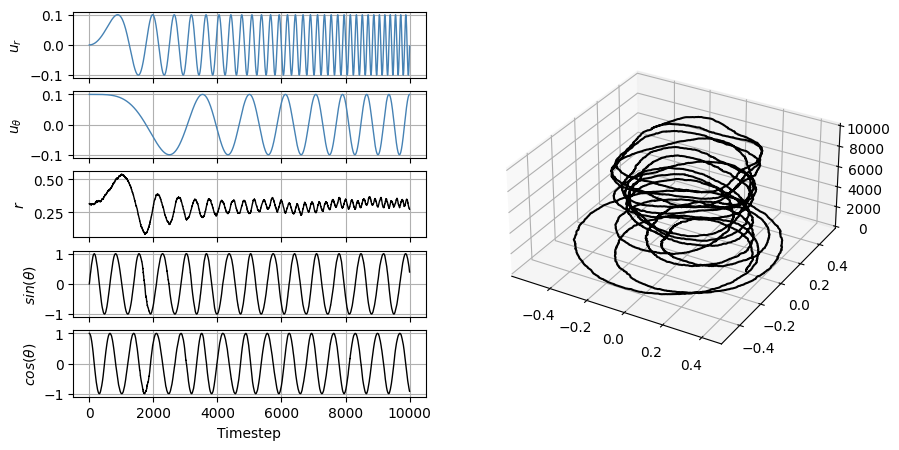

In [6]:
n_steps = 10000
Tf = n_steps * params['dt'] # Terminal time
timesteps = params['dt'] * torch.arange(n_steps+1)
x = torch.zeros((n_steps+1,3))
x[0] = torch.tensor([torch.sqrt(torch.tensor(params['mu'])), 0.0, 1.0])
# x[0] = torch.tensor([torch.sqrt(torch.tensor(params['mu'])), 0.0, 1.0])
# u = -0.05 * torch.cos(2 * np.pi * torch.arange(n_steps-1) / n_steps).reshape(-1,1)
u = torch.hstack((
    0.10 * torch.sin(2 * np.pi * 32 * torch.arange(n_steps)**2 / n_steps**2).reshape(-1,1),
    0.10 * torch.cos(2 * np.pi * 8 * (1-torch.arange(n_steps)**2 / n_steps**2)).reshape(-1,1),
))

# t = torch.arange(n_steps) * params['dt']
# u = torch.hstack((
#     0.10 * torch.sin(2 * np.pi * 10 * (1 + 0.5 * torch.sin(0.05 * t))).reshape(-1,1),
#     0.10 * torch.cos(2 * np.pi * 8 * (1-torch.arange(n_steps)**2 / n_steps**2)).reshape(-1,1),
# ))

for i in range(n_steps):
    x[i+1] = step(x[i], u[i], params)

# Create dataset
dataset_train = StateND(n_states=3, n_inputs=2, info='Stuart-Landau Equation')
dataset_train.append(x[:-1], x[1:], u)

plot_trajectories(x, u, threeD=True, colors=['k', 'k'])

x_last = x[-1]

### Test data

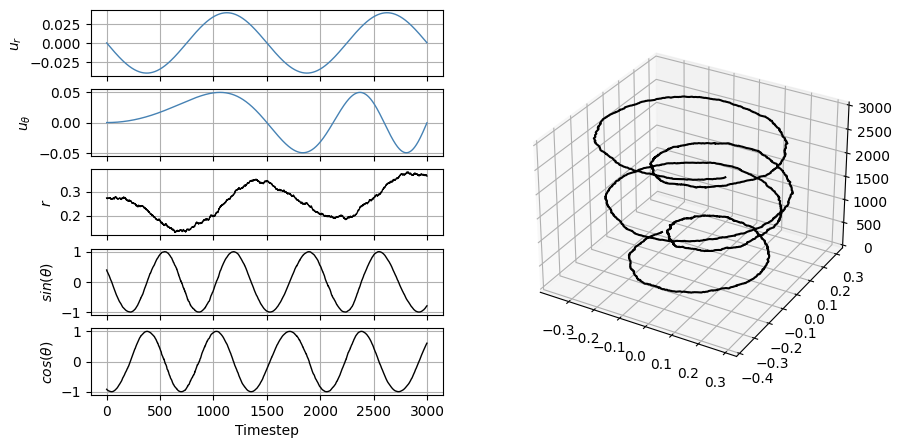

In [7]:
n_steps = 3000
Tf = n_steps * params['dt'] # Terminal time
timesteps = params['dt'] * torch.arange(n_steps+1)
x = torch.zeros((n_steps+1,3))
# x[0] = torch.tensor([torch.sqrt(torch.tensor(params['mu'])), 1.0, 0.0])
x[0] = x_last
# u = 0.0 * np.ones((n_steps - 1,1))
# u = -0.025 * torch.sin(2 * np.pi * 2 * torch.arange(n_steps-1) / n_steps).reshape(-1,1)
u = torch.hstack((
    -0.04 * torch.sin(2 * np.pi * 2 * torch.arange(n_steps) / n_steps).reshape(-1,1),
    -0.05 * torch.sin(2 * np.pi * 2 * (1-torch.arange(n_steps)**2 / n_steps**2)).reshape(-1,1),
))

for i in range(n_steps):
    x[i+1] = step(x[i], u[i], params)

# Create dataset
dataset_test = StateND(n_states=3, n_inputs=2, info='Stuart-Landau Equation')
dataset_test.append(x[:-1], x[1:], u)

plot_trajectories(x, u, threeD=True, colors=['k', 'k'])

## Plot Training + Test Data

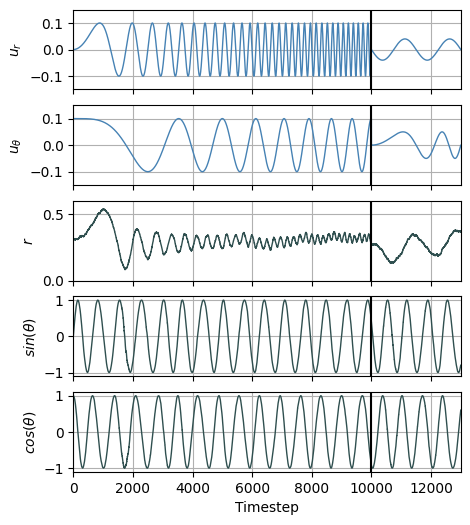

In [8]:
dataset_all = StateND(n_states=3, n_inputs=2, info='Stuart-Landau Equation')
dataset_all.append(dataset_train.Y, dataset_train.Y_plus, dataset_train.U)
dataset_all.append(dataset_test.Y, dataset_test.Y_plus, dataset_test.U)

fig = plt.figure(figsize=(5,6))

ax = fig.add_subplot(511)
ax.plot(dataset_all.U[:,0], c='steelblue', lw=1)
ax.vlines(10000, ymin=-0.15, ymax=0.15, color='k', lw=1.5, zorder=10)
ax.set_xlim([0,len(dataset_all.Y)])
ax.set_ylim([-0.15, 0.15])
ax.set_ylabel('$u_r$')
ax.grid()
ax.xaxis.set_ticklabels([])

ax = fig.add_subplot(512)
ax.plot(dataset_all.U[:,1], c='steelblue', lw=1)
ax.vlines(10000, ymin=-0.15, ymax=0.15, color='k', lw=1.5, zorder=10)
ax.set_xlim([0,len(dataset_all.Y)])
ax.set_ylim([-0.15, 0.15])
ax.set_ylabel('$u_{\\theta}$')
ax.grid()
ax.xaxis.set_ticklabels([])

ax = fig.add_subplot(513)
ax.plot(dataset_all.Y[:,0], c='darkslategrey', lw=1)
ax.vlines(10000, ymin=0, ymax=0.6, color='k', lw=1.5, zorder=10)
ax.set_xlim([0,len(dataset_all.Y)])
ax.set_ylim([0, 0.6])
ax.set_ylabel('$r$')
ax.grid()
ax.xaxis.set_ticklabels([])

ax = fig.add_subplot(514)
ax.plot(dataset_all.Y[:,1], c='darkslategrey', lw=1)
ax.vlines(10000, ymin=-1.1, ymax=1.1, color='k', lw=1.5, zorder=10)
ax.set_xlim([0,len(dataset_all.Y)])
ax.set_ylim([-1.1, 1.1])
ax.set_ylabel('$sin(\\theta)$')
ax.grid()
ax.xaxis.set_ticklabels([])

ax = fig.add_subplot(515)
ax.plot(dataset_all.Y[:,2], c='darkslategrey', lw=1)
ax.vlines(10000, ymin=-1.1, ymax=1.1, color='k', lw=1.5, zorder=10)
ax.set_xlim([0,len(dataset_all.Y)])
ax.set_ylim([-1.1, 1.1])
ax.set_ylabel('$cos(\\theta)$')
ax.set_xlabel('Timestep')
ax.grid()

plt.savefig('figs/sl_data.pdf')

# Test Parameters

In [9]:
N = 256
batch = 64

# DMDc

In [10]:
nx = 3
ny = 3
na = 2
# y_mean = torch.zeros(nx)
# dmdc_model = DMDcModel(nx=nx, ny=ny, nu=na, y_mean=y_mean)
dmdc_model = DMDcModel(nx=nx, ny=ny, nu=na)
dmdc_model.train(dataset_train)

Number of snapshots: 9999
rtil =  3  out of  3
DMD model computed. Error: 0.5247553436282617 %
Maximum eigenvalue magnitude: 0.9996500803112949
DMD training done. Time: 0.0043675899505615234 s.


## Mean Error

In [11]:
mean_error_dmdc = compute_errors(dmdc_model, dataset_test, N=N, batch=batch)
print('Mean error = ', mean_error_dmdc * 100, '%')

  0%|          | 0/64 [00:00<?, ?it/s]

Mean error =  19.83500552459948 %


## Predict

In [12]:
dataset = dataset_test
# dataset = dataset_train
n_steps = len(dataset)

x_pred = torch.zeros((n_steps+1, nx))
x_pred[0] = dataset.Y[0]
u = dataset.U

for i in tqdm(range(n_steps)):
    x_pred[i+1], _ = dmdc_model.forward(x_pred[i], u[i])

error_dmdc = prediction_error(x_pred[:-1], dataset.Y)

  0%|          | 0/3000 [00:00<?, ?it/s]

/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

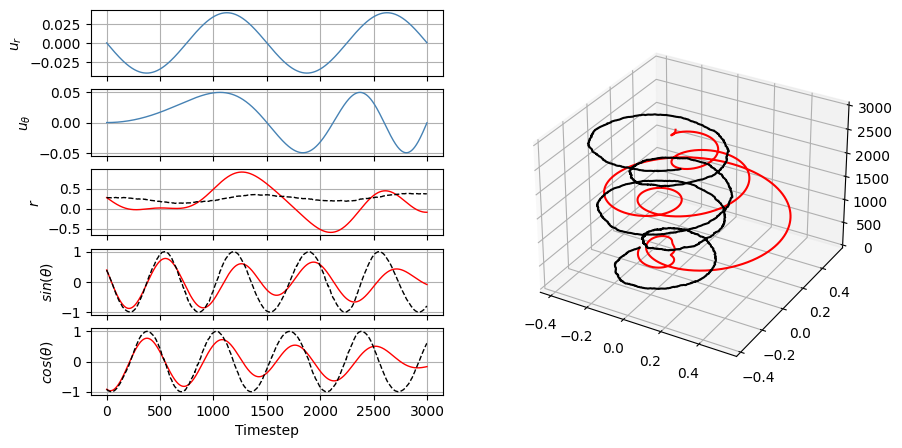

In [13]:
plot_trajectories(x_pred, u, x_exact=dataset.Y, threeD=True)

/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

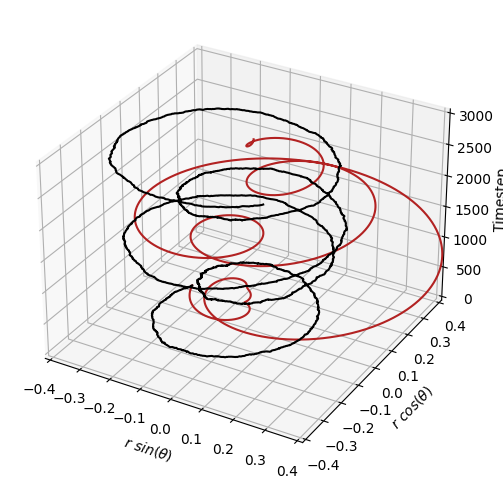

In [14]:
plot_3d(x_pred, x_exact=dataset.Y, saveas='figs/test_3d_' + params['name'] + '_dmdc.pdf')

# tlsDMDc

In [15]:
nx = 3
ny = 3
na = 2
tlsdmdc_model = tlsDMDcModel(nx=nx, ny=ny, nu=na)
tlsdmdc_model.train(dataset_train)

Number of snapshots: 9999
DMD model computed. Error: 0.36649523793778754 %
Maximum eigenvalue magnitude: 0.999984241136478
DMD training done. Time: 1.470808744430542 s.


## Mean Error

In [16]:
mean_error_tlsdmdc = compute_errors(tlsdmdc_model, dataset_test, N=N, batch=batch)
print('Mean error = ', mean_error_tlsdmdc * 100, '%')

  0%|          | 0/64 [00:00<?, ?it/s]

Mean error =  6.649173312519258 %


## Predict

  0%|          | 0/3000 [00:00<?, ?it/s]

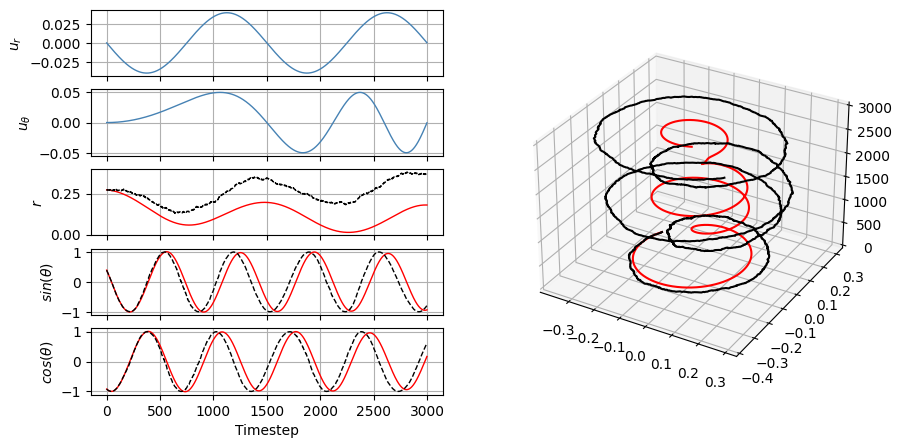

In [17]:
dataset = dataset_test
# dataset = dataset_train
n_steps = len(dataset)

x_pred = torch.zeros((n_steps+1, nx))
x_pred[0] = dataset.Y[0]
u = dataset.U

for i in tqdm(range(n_steps)):
    x_pred[i+1], _ = tlsdmdc_model.forward(x_pred[i], u[i])

error_tlsdmdc = prediction_error(x_pred[:-1], dataset.Y)

plot_trajectories(x_pred, u, x_exact=dataset.Y, threeD=True)

/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

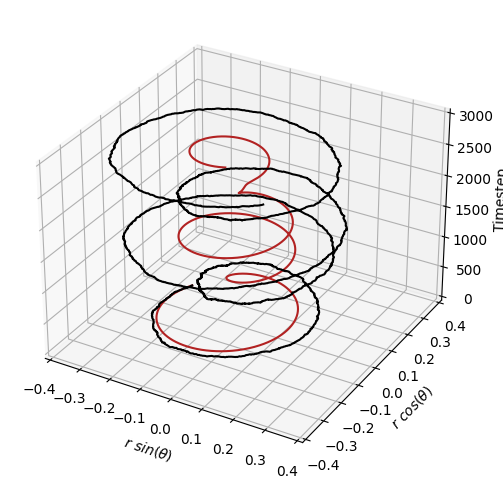

In [18]:
plot_3d(x_pred, x_exact=dataset.Y, saveas='figs/test_3d_' + params['name'] + '_tlsdmdc.pdf')

# DMDc + GP

In [19]:
nx = 3
ny = 3
na = 2
dmdcgp_model = DMDcGPModel(nx=nx, ny=ny, nu=na)

In [20]:
dmdcgp_model.train(dataset_train, training_iter=300, lr=0.1, min_sigma=1.e-4, gp_data_skip=5, cuda=True)

Number of snapshots: 9999
rtil =  3  out of  3
DMD model computed. Error: 0.5247553436282617 %
Maximum eigenvalue magnitude: 0.9996500803112949
DMD training done. Time: 0.0032896995544433594 s.


Training GP Hyperparameters | Loss = -4.8186: 100%|██████████| 300/300 [00:59<00:00,  5.06it/s]

Finished Training
GP training done. Time: 59.96676206588745 s.
Total training done. Time: 59.96986198425293 s.


## Mean Error

In [21]:
mean_error_dmdcgp = compute_errors(dmdcgp_model, dataset_test, N=N, batch=batch)
print('Mean error = ', mean_error_dmdcgp * 100, '%')

  0%|          | 0/64 [00:00<?, ?it/s]

Mean error =  5.177685861479789 %


## Predict

In [22]:
dataset = dataset_test
# dataset = dataset_train
n_steps = len(dataset)

x_pred = torch.zeros((n_steps+1, nx))
x_pred[0] = dataset.Y[0]
x_std = torch.zeros((n_steps+1, nx))
x_cov = torch.zeros((n_steps+1, nx, nx))
u = dataset.U

start_time = time.time()
for i in tqdm(range(n_steps)):
    x_pred[i+1], _, x_std_tmp = dmdcgp_model.forward(x_pred[i], u[i], return_std=True)
    x_cov[i+1] = dmdcgp_model.A @ x_cov[i] @ dmdcgp_model.A.T + torch.diag(x_std_tmp)**2
    x_std[i+1] = torch.diag(x_cov[i+1])

error_dmdcgp = prediction_error(x_pred[:-1], dataset.Y)
print(f'Time: {time.time() - start_time: .4f} s')

  0%|          | 0/3000 [00:00<?, ?it/s]

Time:  20.4831 s


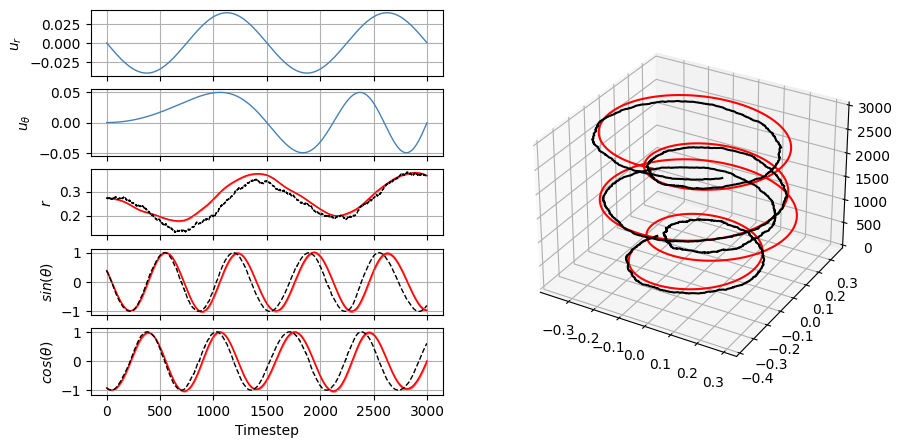

In [23]:
plot_trajectories(x_pred, u, x_exact=dataset.Y, x_std=x_std, n_sigma=3, threeD=True)

/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

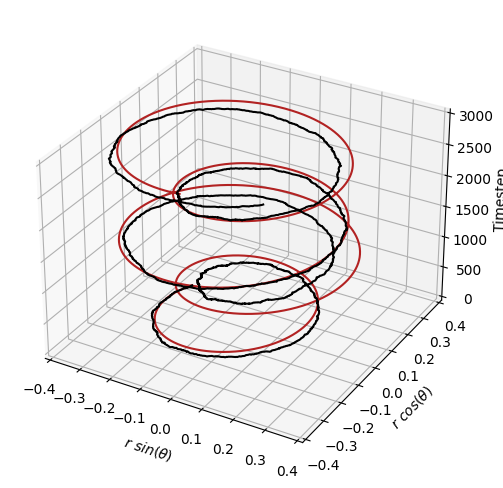

In [24]:
plot_3d(x_pred, x_exact=dataset.Y, saveas='figs/test_3d_' + params['name'] + '_dmdcgp.pdf')

# tlsDMDc + GP

In [25]:
nx = 3
ny = 3
na = 2
tlsdmdcgp_model = tlsDMDcGPModel(nx=nx, ny=ny, nu=na)

In [26]:
tlsdmdcgp_model.train(dataset_train, training_iter=200, lr=0.1, min_sigma=1.e-4, gp_data_skip=5, cuda=True)

Number of snapshots: 9999
DMD model computed. Error: 0.36649523793778754 %
Maximum eigenvalue magnitude: 0.999984241136478
DMD training done. Time: 1.4672434329986572 s.


Training GP Hyperparameters | Loss = -4.8258: 100%|██████████| 200/200 [00:39<00:00,  5.11it/s]


Finished Training
GP training done. Time: 39.16883826255798 s.
Total training done. Time: 40.635220527648926 s.


## Mean Error

In [27]:
mean_error_tlsdmdcgp = compute_errors(tlsdmdcgp_model, dataset_test, N=N, batch=batch)
print('Mean error = ', mean_error_tlsdmdcgp * 100, '%')

  0%|          | 0/64 [00:00<?, ?it/s]

Mean error =  6.985655899408133 %


## Predict

In [28]:
dataset = dataset_test
# dataset = dataset_train
n_steps = len(dataset)

x_pred = torch.zeros((n_steps+1, nx))
x_pred[0] = dataset.Y[0]
x_std = torch.zeros((n_steps+1, nx))
x_cov = torch.zeros((n_steps+1, nx, nx))
u = dataset.U

start_time = time.time()
for i in tqdm(range(n_steps)):
    x_pred[i+1], _, x_std_tmp = tlsdmdcgp_model.forward(x_pred[i], u[i], return_std=True)
    x_cov[i+1] = tlsdmdcgp_model.A @ x_cov[i] @ tlsdmdcgp_model.A.T + torch.diag(x_std_tmp)**2
    x_std[i+1] = torch.diag(x_cov[i+1])

error_tlsdmdcgp = prediction_error(x_pred[:-1], dataset.Y)
print(f'Time: {time.time() - start_time: .4f} s')

  0%|          | 0/3000 [00:00<?, ?it/s]

Time:  20.3277 s


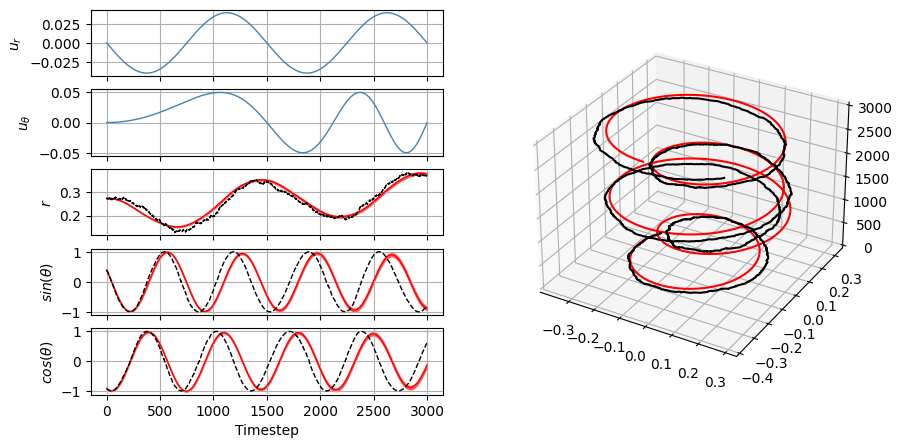

In [29]:
plot_trajectories(x_pred, u, x_exact=dataset.Y, x_std=x_std, n_sigma=3, threeD=True)

/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

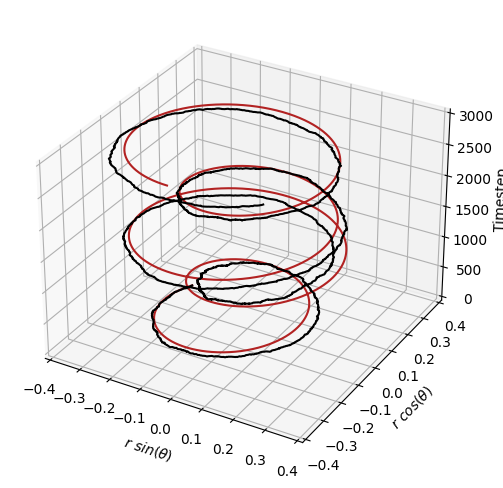

In [30]:
plot_3d(x_pred, x_exact=dataset.Y, saveas='figs/test_3d_' + params['name'] + '_tlsdmdcgp.pdf')

# GP

In [31]:
nx = 3
ny = 3
na = 2
gp_model = GPModel(nx=nx, ny=ny, nu=na)

In [32]:
gp_model.train(dataset_train, training_iter=300, lr=0.1, min_sigma=1.e-4, gp_data_skip=5, cuda=True)

Number of snapshots: 9999


Training GP Hyperparameters | Loss = -4.7997: 100%|██████████| 300/300 [00:59<00:00,  5.05it/s]

Finished Training
Total training done. Time: 59.446215867996216 s.


## Mean Error

In [33]:
mean_error_gp = compute_errors(gp_model, dataset_test, N=N, batch=batch)
print('Mean error = ', mean_error_gp * 100, '%')

  0%|          | 0/64 [00:00<?, ?it/s]

Mean error =  6.35290405895374 %


## Predict

In [34]:
dataset = dataset_test
# dataset = dataset_train
n_steps = len(dataset)

x_pred = torch.zeros((n_steps+1, nx))
x_pred[0] = dataset.Y[0]
x_std = torch.zeros((n_steps+1, nx))
x_cov = torch.zeros((n_steps+1, nx, nx))
u = dataset.U

start_time = time.time()
for i in tqdm(range(n_steps)):
    x_pred[i+1], _, x_std_tmp = gp_model.forward(x_pred[i], u[i], return_std=True)
    x_cov[i+1] = gp_model.A @ x_cov[i] @ gp_model.A.T + torch.diag(x_std_tmp)**2
    x_std[i+1] = torch.diag(x_cov[i+1])

error_gp = prediction_error(x_pred[:-1], dataset.Y)
print(f'Time: {time.time() - start_time: .4f} s')

  0%|          | 0/3000 [00:00<?, ?it/s]

Time:  20.3188 s


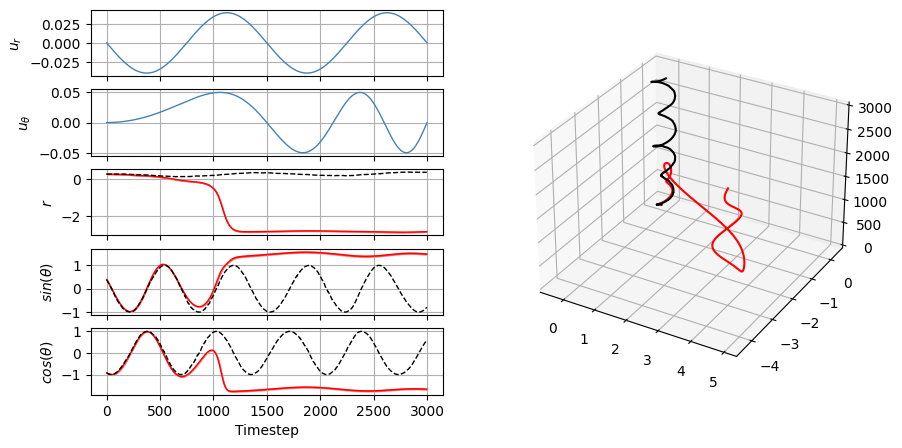

In [35]:
plot_trajectories(x_pred, u, x_exact=dataset.Y, x_std=x_std, n_sigma=3, threeD=True)

/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/at38585/miniconda3/envs/torch_env/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs,

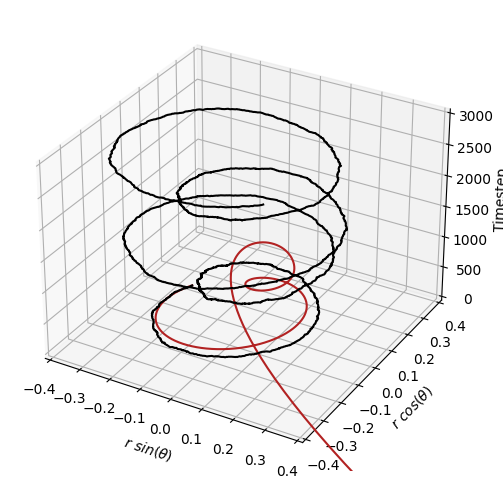

In [36]:
plot_3d(x_pred, x_exact=dataset.Y, saveas='figs/test_3d_' + params['name'] + '_gp.pdf')

# Model Errors

DMDc:         tensor(0.6707)
tlsDMDc:      tensor(0.4560)
DMDcGP:       tensor(0.3790)
tlsDMDcGP:    tensor(0.5779)
GP:           tensor(2.5041)


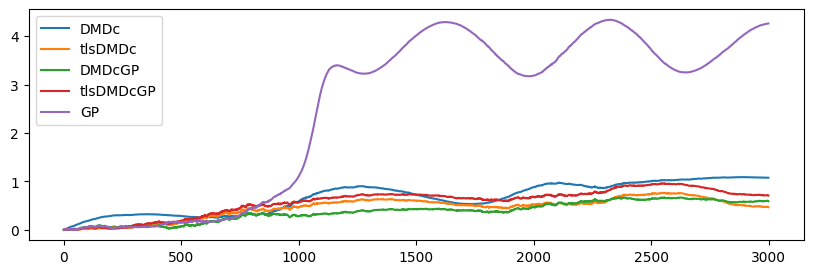

In [37]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(error_dmdc, label='DMDc')
ax.plot(error_tlsdmdc, label='tlsDMDc')
ax.plot(error_dmdcgp, label='DMDcGP')
ax.plot(error_tlsdmdcgp, label='tlsDMDcGP')
ax.plot(error_gp, label='GP')
ax.legend()

print('DMDc:        ', error_dmdc.mean())
print('tlsDMDc:     ', error_tlsdmdc.mean())
print('DMDcGP:      ', error_dmdcgp.mean())
print('tlsDMDcGP:   ', error_tlsdmdcgp.mean())
print('GP:          ', error_gp.mean())

# MPC

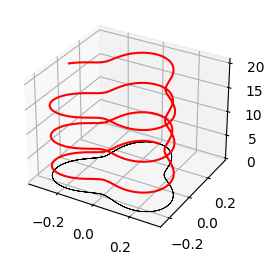

In [38]:
n_steps = 2050
t = torch.arange(n_steps) * params['dt']
r_des = 0.15 * np.cos(t * 1.5)**2 + 0.2

x_init = torch.tensor([0.1, 0.5, -0.5])

x_des = torch.vstack((
    r_des,
    torch.sin(t - r_des**3/3 + np.pi/2.),
    torch.cos(t - r_des**3/3 + np.pi/2.),
)).T

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111, projection='3d')
xp = x_des[:,0] * x_des[:,2]
yp = x_des[:,0] * x_des[:,1]
ax.plot(xp, yp, lw=0.5, c='k')
ax.set_box_aspect((np.ptp(xp), np.ptp(yp), 0.5))  # aspect ratio is 1:1:1 in data space
ax.plot3D(xp, yp, t, c='r')

# MPC Parameters
u_min = -0.2
u_max = 0.2
Q = [1.0, 1.0, 1.0]
R = [1.e-3, 1.e-3]
N = 50

In [39]:
def plot_controlled(x_pred, inputs, x_exact=None, saveas='controlled.pdf'):

    fig = plt.figure(figsize=(4,9))

    ax = plt.subplot2grid((12, 1), (0, 0))
    ax.plot(inputs[:,0], lw=1.0, c='steelblue')
    ax.grid()
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('$u_{r}$')
    
    ax = plt.subplot2grid((12, 1), (1, 0))
    ax.plot(inputs[:,1], lw=1.0, c='steelblue')
    ax.grid()
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('$u_{\\theta}$')
    
    ax = plt.subplot2grid((12, 1), (2, 0))
    ax.plot(x_pred[:,0], lw=1.0, c='firebrick')
    ax.plot(x_exact[:,0], lw=1.0, c='k', ls='--')
    ax.grid()
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('$r$')

    ax = plt.subplot2grid((12, 1), (3, 0))
    ax.plot(x_pred[:,1], lw=1.0, c='firebrick')
    ax.plot(x_exact[:,1], lw=1.0, c='k', ls='--')
    ax.grid()
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('$sin(\\theta)$')

    ax = plt.subplot2grid((12, 1), (4, 0))
    ax.plot(x_pred[:,2], lw=1.0, c='firebrick')
    ax.plot(x_exact[:,2], lw=1.0, c='k', ls='--')
    ax.grid()
    ax.set_ylabel('$cos(\\theta)$')
    ax.set_xlabel('Timestep')

    
    ax = plt.subplot2grid((12, 1), (5, 0), rowspan=7)

    # Predicted
    xp = x_pred[:,0] * x_pred[:,2]
    yp = x_pred[:,0] * x_pred[:,1]
    
    ax.plot(xp, yp, c='firebrick', lw=1)
    ax.scatter(xp[0], yp[0], color='firebrick', s=20, marker='x')
    
    ax.set_xlabel('$r\ sin(\\theta)$')
    ax.set_ylabel('$r\ cos(\\theta)$')
    ax.set_xlim([-0.45, 0.45])
    ax.set_ylim([-0.45, 0.45])
    
    xp = x_exact[:630,0] * x_exact[:630,2]
    yp = x_exact[:630,0] * x_exact[:630,1]
    ax.plot(xp, yp, c='k', ls='--', lw=1)
    ax.set_aspect('equal', 'box')
    
    plt.savefig(saveas)
    

## Using DMDc

In [40]:
A = dmdc_model.A
B = dmdc_model.B
C = dmdc_model.C

controller = TorchOutputTrackingController(A, B, C, N=N, u_min=u_min, u_max=u_max, Q=Q, R=R)

torch.manual_seed(28)

y_des = x_des @ np.array(C).T
x_pred = torch.zeros((n_steps+1-N, nx))
x_pred[0] = x_init
u = torch.zeros((n_steps-N,2))

for i in tqdm(range(n_steps-N)):
    u_star = controller.compute_input(y_des[i:i+N], x_pred[i])
    u[i] = torch.from_numpy(u_star[:2])
    x_pred[i+1] = step(x_pred[i], u[i], params)

/home/at38585/flow_control/DMDcGP/src/output_tracking_controller.py:81: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  self.DeltadQQGamma = (Delta @ dd).T @ (QQ @ Gamma)


  0%|          | 0/2000 [00:00<?, ?it/s]

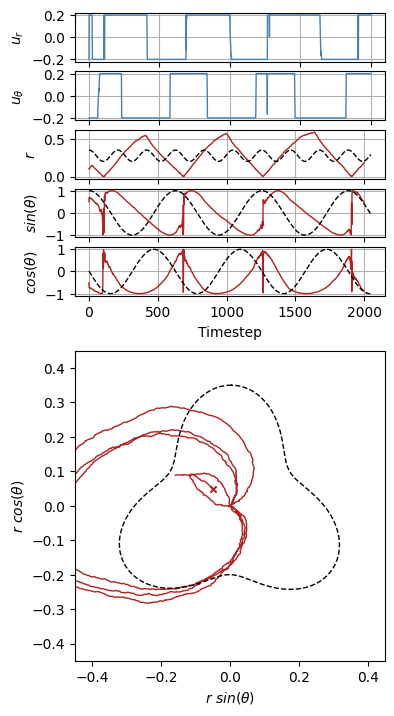

In [41]:
plot_controlled(x_pred, u, x_exact=x_des, saveas='figs/sl_tracking_' + params['name'] + '_dmdc.pdf')

## Using tlsDMDc

In [42]:
A = tlsdmdc_model.A
B = tlsdmdc_model.B
C = tlsdmdc_model.C

controller = TorchOutputTrackingController(A, B, C, N=N, u_min=u_min, u_max=u_max, Q=Q, R=R)

torch.manual_seed(28)

y_des = x_des @ np.array(C).T

x_pred = torch.zeros((n_steps+1-N, nx))
x_pred[0] = x_init
u = torch.zeros((n_steps-N,2))

for i in tqdm(range(n_steps-N)):
    u_star = controller.compute_input(y_des[i:i+N], x_pred[i])
    u[i] = torch.from_numpy(u_star[:2])
    x_pred[i+1] = step(x_pred[i], u[i], params)

tracking_error_tlsdmdc = torch.linalg.norm(x_pred[:-1] - x_des[:-N])/torch.linalg.norm(x_des[:-N])

print('Tracking error: ', tracking_error_tlsdmdc*100, '%')

  0%|          | 0/2000 [00:00<?, ?it/s]

Tracking error:  tensor(42.3953) %


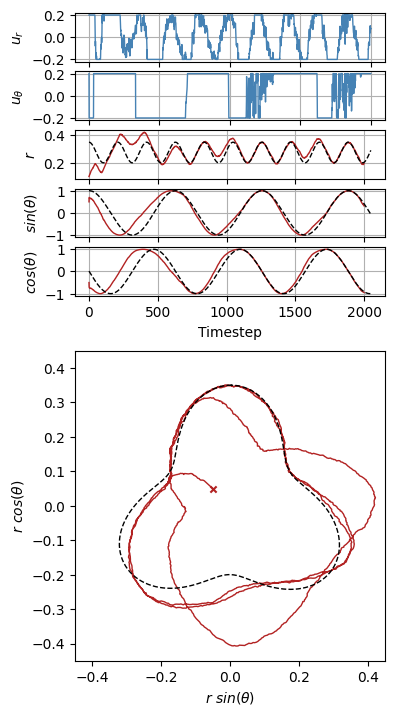

In [43]:
plot_controlled(x_pred, u, x_exact=x_des, saveas='figs/sl_tracking_' + params['name'] + '_tlsdmdc.pdf')

## Using DMDc with GPs

In [44]:
torch.manual_seed(28)

y_des = x_des @ np.array(C).T

x_pred = torch.zeros((n_steps+1-N, nx))
x_pred[0] = x_init
u = torch.zeros((n_steps-N,2))

# Initial linearization
A, B, d = dmdcgp_model.linearize(x_pred[0], u[0])
controller = TorchOutputTrackingController(A, B, C, d=d, N=N, u_min=u_min, u_max=u_max, Q=Q, R=R)

for i in tqdm(range(n_steps-N)):
    u_star = controller.compute_input(y_des[i:i+N], x_pred[i])
    u[i] = torch.from_numpy(u_star[:2])
    x_pred[i+1] = step(x_pred[i], u[i], params)

    # Linearize every few time steps
    if i % 10 == 0:
        A, B, d = dmdcgp_model.linearize(x_pred[i], u[i])
        controller = TorchOutputTrackingController(A, B, C, d=d, N=N, u_min=u_min, u_max=u_max, Q=Q, R=R)

tracking_error_dmdcgp = torch.linalg.norm(x_pred[:-1] - x_des[:-N])/torch.linalg.norm(x_des[:-N])

print('Tracking error: ', tracking_error_dmdcgp*100, '%')

  0%|          | 0/2000 [00:00<?, ?it/s]

Tracking error:  tensor(16.7959) %


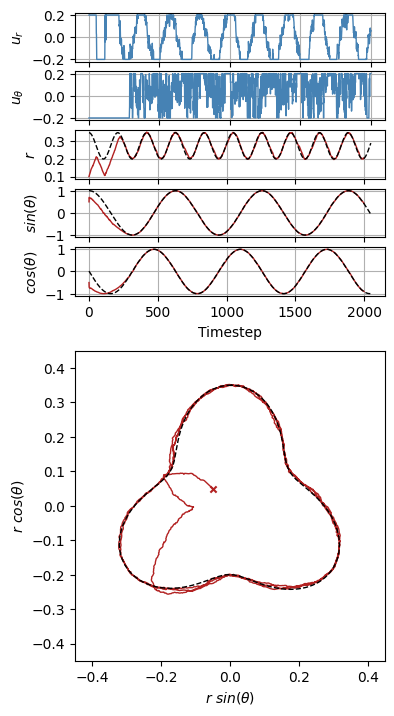

In [45]:
plot_controlled(x_pred, u, x_exact=x_des, saveas='figs/sl_tracking_' + params['name'] + '_dmdcgp.pdf')

## Using tlsDMDc with GPs

In [46]:
torch.manual_seed(28)

y_des = x_des @ np.array(C).T

x_pred = torch.zeros((n_steps+1-N, nx))
x_pred[0] = x_init
u = torch.zeros((n_steps-N,2))

# Initial linearization
A, B, d = tlsdmdcgp_model.linearize(x_pred[0], u[0])
controller = TorchOutputTrackingController(A, B, C, d=d, N=N, u_min=u_min, u_max=u_max, Q=Q, R=R)

for i in tqdm(range(n_steps-N)):
    u_star = controller.compute_input(y_des[i:i+N], x_pred[i])
    u[i] = torch.from_numpy(u_star[:2])
    x_pred[i+1] = step(x_pred[i], u[i], params)
    
    # Linearize every few time steps
    if i % 10 == 0:
        A, B, d = tlsdmdcgp_model.linearize(x_pred[i], u[i])
        controller = TorchOutputTrackingController(A, B, C, d=d, N=N, u_min=u_min, u_max=u_max, Q=Q, R=R)
    
tracking_error_tlsdmdcgp = torch.linalg.norm(x_pred[:-1] - x_des[:-N])/torch.linalg.norm(x_des[:-N])

print('Tracking error: ', tracking_error_tlsdmdcgp*100, '%')

  0%|          | 0/2000 [00:00<?, ?it/s]

Tracking error:  tensor(40.2258) %


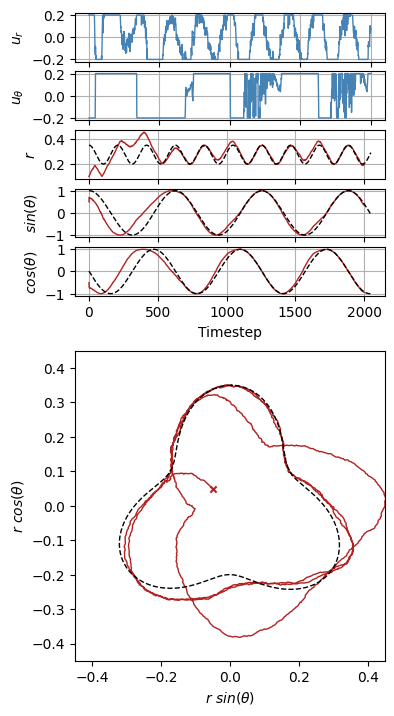

In [47]:
plot_controlled(x_pred, u, x_exact=x_des, saveas='figs/sl_tracking_' + params['name'] + '_tlsdmdcgp.pdf')

## GPs

In [48]:
torch.manual_seed(28)

y_des = x_des @ np.array(C).T

x_pred = torch.zeros((n_steps+1-N, nx))
x_pred[0] = x_init
u = torch.zeros((n_steps-N,2))

# Initial linearization
A, B, d = gp_model.linearize(x_pred[0], u[0])
controller = TorchOutputTrackingController(A, B, C, d=d, N=N, u_min=u_min, u_max=u_max, Q=Q, R=R)

for i in tqdm(range(n_steps-N)):
    u_star = controller.compute_input(y_des[i:i+N], x_pred[i])
    u[i] = torch.from_numpy(u_star[:2])
    x_pred[i+1] = step(x_pred[i], u[i], params)
    
    # Linearize every few time steps
    if i % 10 == 0:
        A, B, d = gp_model.linearize(x_pred[i], u[i])
        controller = TorchOutputTrackingController(A, B, C, d=d, N=N, u_min=u_min, u_max=u_max, Q=Q, R=R)

tracking_error_gp = torch.linalg.norm(x_pred[:-1] - x_des[:-N])/torch.linalg.norm(x_des[:-N])

print('Tracking error: ', tracking_error_gp*100, '%')

  0%|          | 0/2000 [00:00<?, ?it/s]

Tracking error:  tensor(64.3795) %


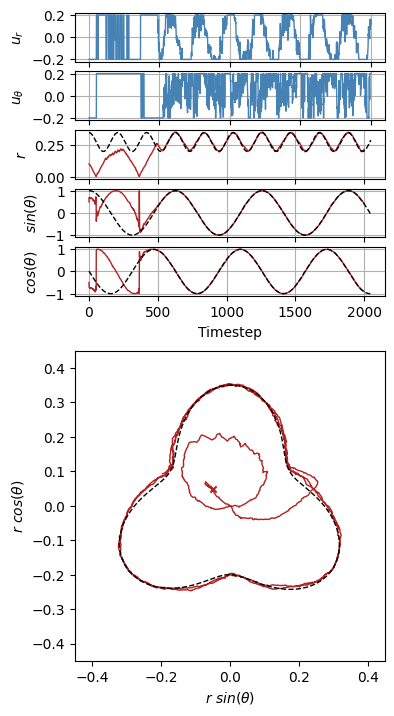

In [49]:
plot_controlled(x_pred, u, x_exact=x_des, saveas='figs/sl_tracking_' + params['name'] + '_gp.pdf')